# Ejercicio 2 - NEURIPS BELKA


In [38]:
import numpy as np #
import pandas as pd #
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit import RDLogger
import pickle
import matplotlib.image as mpimg
import seaborn as sns
import duckdb
from matplotlib_venn import venn3, venn2
from venny4py.venny4py import *
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import missingno as msno
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import gc
from sklearn.feature_selection import SelectKBest, chi2
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [39]:

file_path = '/content/drive/My Drive/train.parquet'
#test = pd.read_parquet('/content/drive/My Drive/test.parquet',engine='pyarrow')
#df = pd.read_parquet(file_path,engine='pyarrow')

In [40]:
df = pd.read_excel('train_head.xlsx')
df

id                            buildingblock1_smiles buildingblock2_smiles  \
0   0  C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21  C#CCOc1ccc(CN)cc1.Cl   
1   1  C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21  C#CCOc1ccc(CN)cc1.Cl   
2   2  C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21  C#CCOc1ccc(CN)cc1.Cl   
3   3  C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21  C#CCOc1ccc(CN)cc1.Cl   
4   4  C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21  C#CCOc1ccc(CN)cc1.Cl   

     buildingblock3_smiles                                    molecule_smiles  \
0  Br.Br.NCC1CCCN1c1cccnn1  C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...   
1  Br.Br.NCC1CCCN1c1cccnn1  C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...   
2  Br.Br.NCC1CCCN1c1cccnn1  C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...   
3        Br.NCc1cccc(Br)n1  C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...   
4        Br.NCc1cccc(Br)n1  C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...   

  protein_name  binds  
0         BRD4      0  
1          HSA      0  
2          sEH      0  
3         BRD4      0  
4          HSA      0

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     5 non-null      int64 
 1   buildingblock1_smiles  5 non-null      object
 2   buildingblock2_smiles  5 non-null      object
 3   buildingblock3_smiles  5 non-null      object
 4   molecule_smiles        5 non-null      object
 5   protein_name           5 non-null      object
 6   binds                  5 non-null      int64 
dtypes: int64(2), object(5)
memory usage: 408.0+ bytes


Vemos que las unicas variables variables numericas son el 'id' y 'binds'. La primera corresponde a la identificacion de las cadenas quimicas que son la parte central del DataFrame, la segunda variable corresponde a la variable objetivo, correspondiente a la probabilidad de ocurrencia.

In [42]:
df.isnull().sum()

id                       0
buildingblock1_smiles    0
buildingblock2_smiles    0
buildingblock3_smiles    0
molecule_smiles          0
protein_name             0
binds                    0
dtype: int64

En esta parte hacemos el correspondiente conteo de datos faltantes, por columna, y resulta que no hay ningun dato faltante, cosa que se aprecia bastante.

In [43]:
train_bdr4=df[df["protein_name"]=="BRD4"].reset_index(drop=True)
train_bdr4.head()

id                            buildingblock1_smiles buildingblock2_smiles  \
0   0  C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21  C#CCOc1ccc(CN)cc1.Cl   
1   3  C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21  C#CCOc1ccc(CN)cc1.Cl   

     buildingblock3_smiles                                    molecule_smiles  \
0  Br.Br.NCC1CCCN1c1cccnn1  C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...   
1        Br.NCc1cccc(Br)n1  C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...   

  protein_name  binds  
0         BRD4      0  
1         BRD4      0

In [44]:
train_hsa=df[df["protein_name"]=="HSA"].reset_index(drop=True)
train_hsa.head()

id                            buildingblock1_smiles buildingblock2_smiles  \
0   1  C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21  C#CCOc1ccc(CN)cc1.Cl   
1   4  C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21  C#CCOc1ccc(CN)cc1.Cl   

     buildingblock3_smiles                                    molecule_smiles  \
0  Br.Br.NCC1CCCN1c1cccnn1  C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...   
1        Br.NCc1cccc(Br)n1  C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...   

  protein_name  binds  
0          HSA      0  
1          HSA      0

In [45]:
train_seh=df[df["protein_name"]=="sEH"].reset_index(drop=True)
train_seh.head()

id                            buildingblock1_smiles buildingblock2_smiles  \
0   2  C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21  C#CCOc1ccc(CN)cc1.Cl   

     buildingblock3_smiles                                    molecule_smiles  \
0  Br.Br.NCC1CCCN1c1cccnn1  C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...   

  protein_name  binds  
0          sEH      0

Separamos los registros de cadenas quimicas que tenemos segun el tipo de proteina asociada, donde vemos que hay la siguiente cantiddad de registros:

1.   98415610 : BDR4
1.   98415610 : HSA
3.   98415610 : sEH

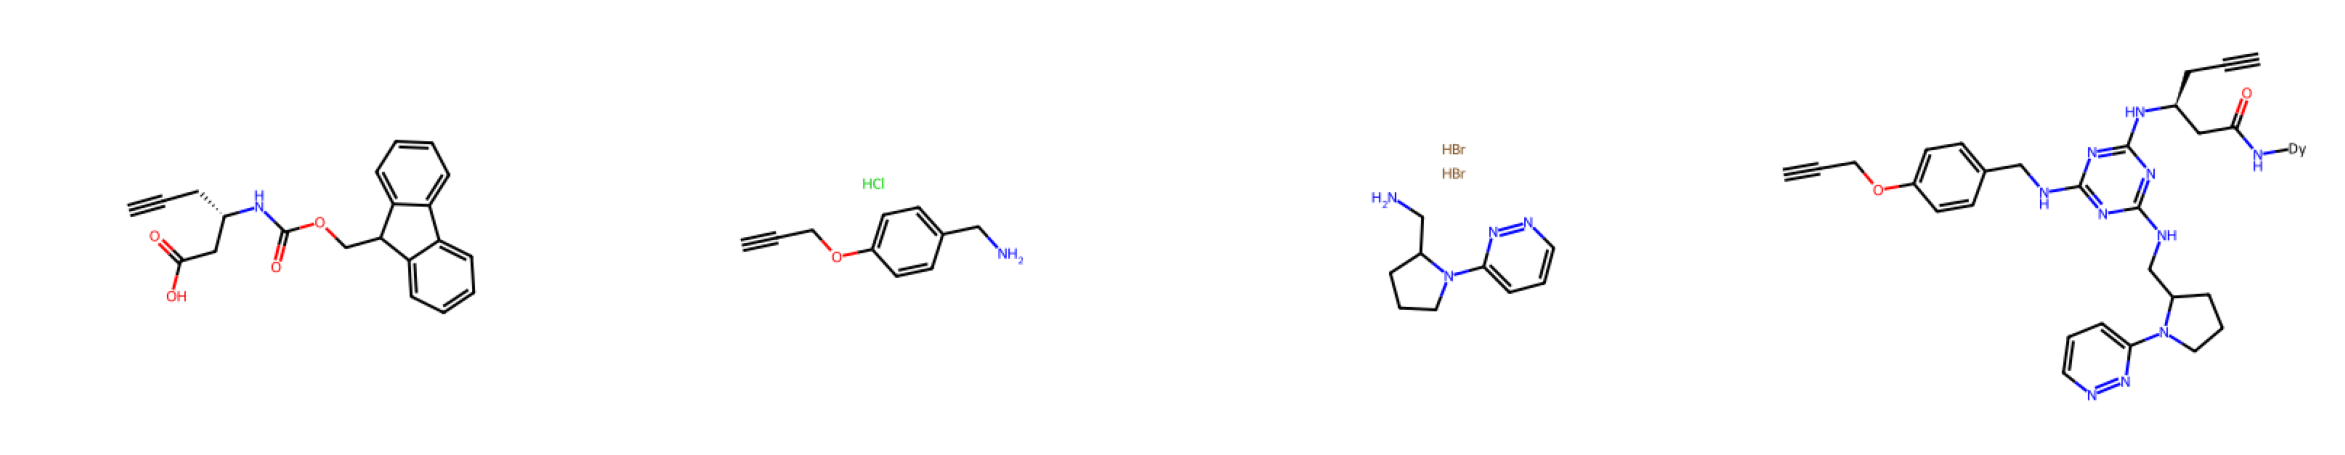

In [46]:
'''def plot_mols(df, mol_count):
    df2=df.reset_index(drop=True)
    mols = []
    for i in range(mol_count):
        mols+=[Chem.MolFromSmiles(df2['buildingblock1_smiles'][i]),Chem.MolFromSmiles(df2['buildingblock2_smiles'][i]),Chem.MolFromSmiles(df2['buildingblock3_smiles'][i]),Chem.MolFromSmiles(df2['molecule_smiles'][i])]
    return Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(400,300))

plot_mols(df, 1)'''
plt.figure(figsize=(30, 20))  
img = mpimg.imread('cadenas1.png')
plt.imshow(img)
plt.axis('off')  
plt.show()

apreciamos distintas visualizaciones de las cadenas organicas, estas cadenas provienen de los datos train.

In [47]:
df_bind1 = df[df['binds'] == 1]
df_bind0 = df[df['binds'] == 0]

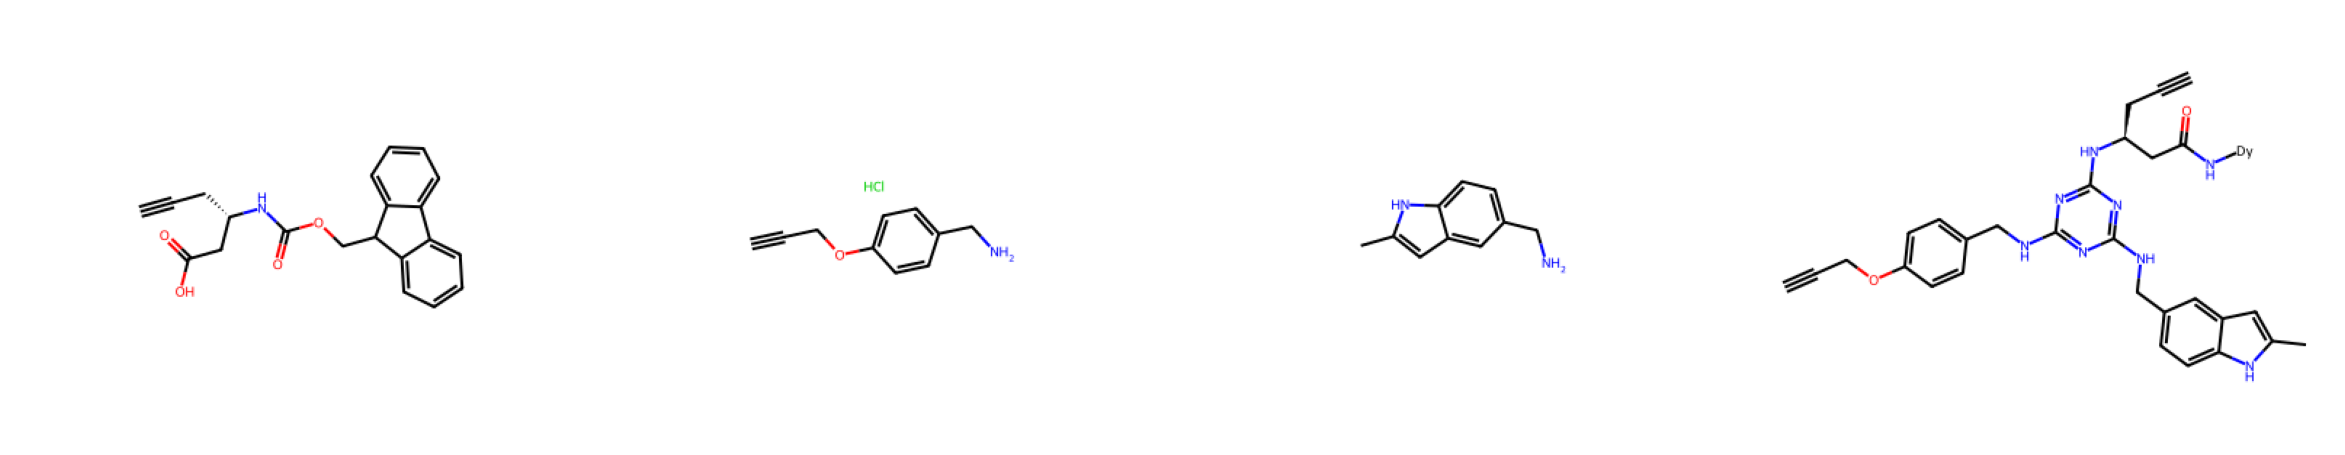

In [48]:
'''plot_mols(df_bind1[0:500], 1)'''
plt.figure(figsize=(30, 20))  
img = mpimg.imread('cadenas2.png')
plt.imshow(img)
plt.axis('off')  
plt.show()

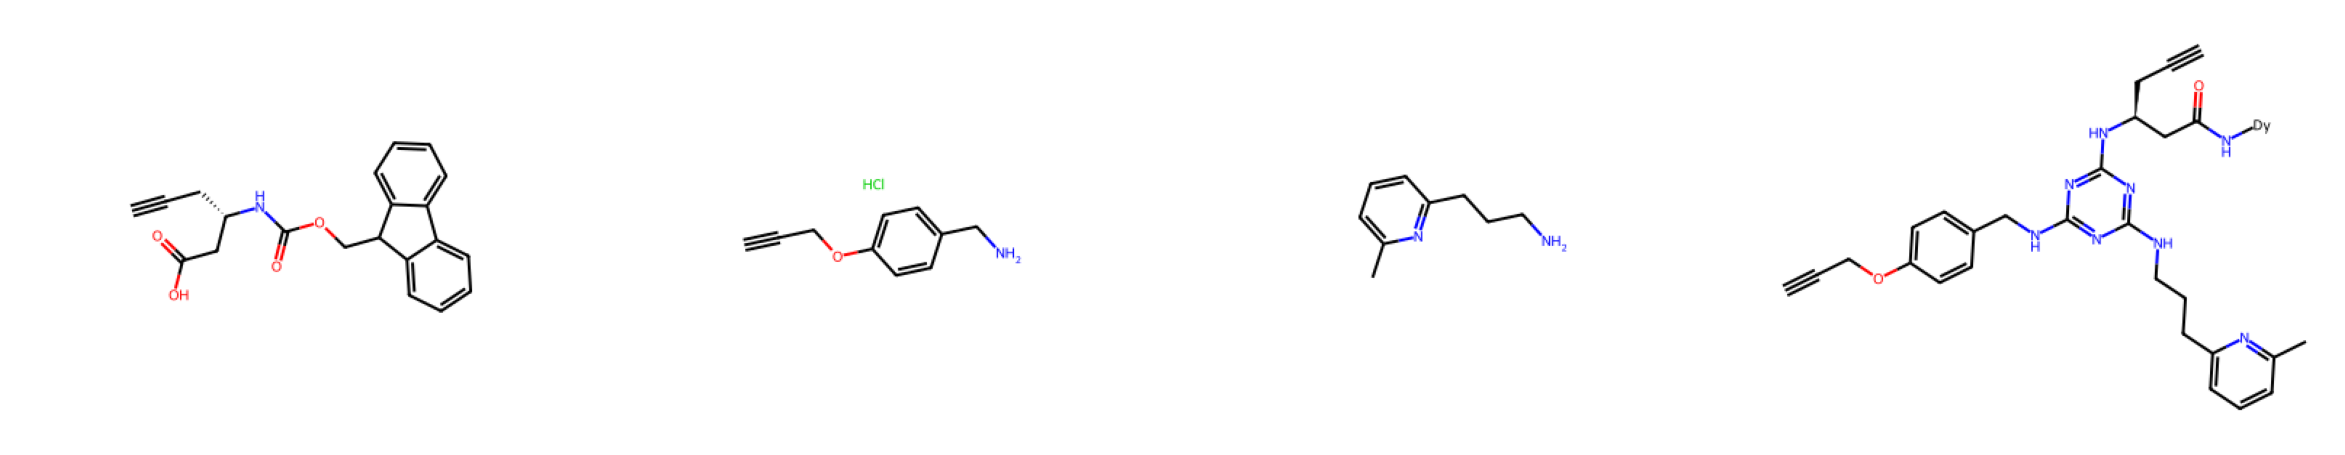

In [49]:
'''plot_mols(df_bind0[500:1000], 1)'''
plt.figure(figsize=(30, 20))  
img = mpimg.imread('cadenas3.png')
plt.imshow(img)
plt.axis('off')  
plt.show()


Para las ultimas dos visualizaciones tenemos infromacion proveniente de los datos train tambien. Sin embargo, estos corresponde a datos agrupados segun las probabilidades 0 y 1, respectivamente.

### Dato importante

Debido a la gran masa de datos con la que contamos, los dato seran divididos en tres parte segun las protein que hay :


1.   sEH
2.   BDR4
3.   HSA

Esto con el fin de manejar mejor los datos para la produccion de un mejor modelo.

\
Por lo tanto cobran gran importancia estas variables:


1.   train_seh, test_seh

2.   train_bdr4, test_bdr4

3.   train_hsa, test_hsa








In [50]:
'''test_seh=test[test["protein_name"]=="sEH"].reset_index(drop=True)'''
test_seh = pd.read_excel('test_seh.xlsx')
test_seh.head()

id                            buildingblock1_smiles  \
0  295246832  C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
1  295246835  C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
2  295246838  C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
3  295246841  C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
4  295246844  C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   

  buildingblock2_smiles   buildingblock3_smiles  \
0        C=Cc1ccc(N)cc1          C=Cc1ccc(N)cc1   
1        C=Cc1ccc(N)cc1  CC(O)Cn1cnc2c(N)ncnc21   
2        C=Cc1ccc(N)cc1        CC1(C)CCCC1(O)CN   
3        C=Cc1ccc(N)cc1     COC(=O)c1cc(Cl)sc1N   
4        C=Cc1ccc(N)cc1          CSC1CCC(CN)CC1   

                                     molecule_smiles protein_name  
0  C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...          sEH  
1  C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...          sEH  
2  C#CCCC[C@H](Nc1nc(NCC2(O)CCCC2(C)C)nc(Nc2ccc(C...          sEH  
3  C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2sc(Cl)c...          sEH  
4  C#CCCC[C@H](Nc1nc(NCC2CCC(SC)CC2)nc(Nc2ccc(C=C...          sEH

In [51]:
'''test_bdr4=test[test["protein_name"]=="BRD4"].reset_index(drop=True)'''
test_bdr4 = pd.read_excel('test_bdr4.xlsx')
test_bdr4.head()

id                            buildingblock1_smiles  \
0  295246830  C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
1  295246833  C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
2  295246836  C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
3  295246839  C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
4  295246842  C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   

  buildingblock2_smiles   buildingblock3_smiles  \
0        C=Cc1ccc(N)cc1          C=Cc1ccc(N)cc1   
1        C=Cc1ccc(N)cc1  CC(O)Cn1cnc2c(N)ncnc21   
2        C=Cc1ccc(N)cc1        CC1(C)CCCC1(O)CN   
3        C=Cc1ccc(N)cc1     COC(=O)c1cc(Cl)sc1N   
4        C=Cc1ccc(N)cc1          CSC1CCC(CN)CC1   

                                     molecule_smiles protein_name  
0  C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...         BRD4  
1  C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...         BRD4  
2  C#CCCC[C@H](Nc1nc(NCC2(O)CCCC2(C)C)nc(Nc2ccc(C...         BRD4  
3  C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2sc(Cl)c...         BRD4  
4  C#CCCC[C@H](Nc1nc(NCC2CCC(SC)CC2)nc(Nc2ccc(C=C...         BRD4

In [52]:
'''test_hsa=test[test["protein_name"]=="HSA"].reset_index(drop=True)'''
test_hsa = pd.read_excel('test_hsa.xlsx')
test_hsa.head()

id                            buildingblock1_smiles  \
0  295246831  C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
1  295246834  C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
2  295246837  C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
3  295246840  C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
4  295246843  C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   

  buildingblock2_smiles   buildingblock3_smiles  \
0        C=Cc1ccc(N)cc1          C=Cc1ccc(N)cc1   
1        C=Cc1ccc(N)cc1  CC(O)Cn1cnc2c(N)ncnc21   
2        C=Cc1ccc(N)cc1        CC1(C)CCCC1(O)CN   
3        C=Cc1ccc(N)cc1     COC(=O)c1cc(Cl)sc1N   
4        C=Cc1ccc(N)cc1          CSC1CCC(CN)CC1   

                                     molecule_smiles protein_name  
0  C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...          HSA  
1  C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...          HSA  
2  C#CCCC[C@H](Nc1nc(NCC2(O)CCCC2(C)C)nc(Nc2ccc(C...          HSA  
3  C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2sc(Cl)c...          HSA  
4  C#CCCC[C@H](Nc1nc(NCC2CCC(SC)CC2)nc(Nc2ccc(C=C...          HSA

### Dato importante
se manejara una representacion muestral de los datos, escogida de manera aleatoria, debido a la imposibilidad de convertir las variables en un formato optimo para la creacion de los modelos.

### Ajuste de dimensionalidad

In [53]:
#data_bd4, _ = train_test_split( train_bdr4, train_size = 100000,  stratify = train_bdr4['binds'],  random_state = 11)

In [54]:
#data_hsa, _ = train_test_split( train_hsa, train_size = 100000,  stratify = train_hsa['binds'],  random_state = 11)

In [55]:
#data_seh, _ = train_test_split( train_seh, train_size = 100000,  stratify = train_seh['binds'],  random_state = 11)

In [56]:
data_bd4 = pd.read_excel('data_bd4.xlsx')
data_bd4

Unnamed: 0         id                              buildingblock1_smiles  \
0    33391477  100174431  O=C(N[C@@H](Cc1ccc(F)cc1F)C(=O)O)OCC1c2ccccc2-...   
1    96211546  288634638  O=C(O)[C@H]1CC2CCCCC2N1C(=O)OCC1c2ccccc2-c2ccc...   
2    14602920   43808760  C[C@@H](OCc1ccccc1)[C@H](NC(=O)OCC1c2ccccc2-c2...   
3    30345706   91037118  O=C(N[C@@H](Cc1c(F)c(F)c(F)c(F)c1F)C(=O)O)OCC1...   
4     1157259    3471777     C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21   

    buildingblock2_smiles          buildingblock3_smiles  \
0     Nc1nc(-c2cccnc2)cs1                     Cc1nnsc1CN   
1   Nc1ccncc1[N+](=O)[O-]       Nc1nc2nc[nH]c2c(=O)[nH]1   
2       COc1c(F)cc(N)cc1F                 Nc1ccc(F)cc1CO   
3  Cl.NCCOC1CCS(=O)(=O)C1  Cl.Cl.NCCc1nnc2c(=O)[nH]ccn12   
4         COC(=O)c1scnc1N            NCC1CSCCN1Cc1ccccc1   

                                     molecule_smiles protein_name  binds  
0  Cc1nnsc1CNc1nc(Nc2nc(-c3cccnc3)cs2)nc(N[C@@H](...         BRD4      0  
1  O=C(N[Dy])[C@H]1CC2CCCCC2N1c1nc(Nc2nc3nc[nH]c3...         BRD4      0  
2  COc1c(F)cc(Nc2nc(Nc3ccc(F)cc3CO)nc(N[C@H](C(=O...         BRD4      0  
3  O=C(N[Dy])[C@H](Cc1c(F)c(F)c(F)c(F)c1F)Nc1nc(N...         BRD4      0  
4  C#CC[C@H](CC(=O)N[Dy])Nc1nc(NCC2CSCCN2Cc2ccccc...         BRD4      0

In [57]:
data_seh = pd.read_excel('data_seh.xlsx')
data_seh.head()

Unnamed: 0         id                              buildingblock1_smiles  \
0    49079709  147239129     O=C(Nc1c(Cl)cccc1C(=O)O)OCC1c2ccccc2-c2ccccc21   
1    85996808  257990426  O=C(O)C[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)c1c...   
2    60190358  180571076   O=C(Nc1ccc(Br)c(C(=O)O)c1)OCC1c2ccccc2-c2ccccc21   
3    62315645  186946937  O=C(Nc1ccc(C(=O)O)c([N+](=O)[O-])c1)OCC1c2cccc...   
4    69181222  207543668  O=C(Nc1cccc(-c2cccc(C(=O)O)c2)c1O)OCC1c2ccccc2...   

                  buildingblock2_smiles  buildingblock3_smiles  \
0                       CNC(=O)COCCN.Cl        CN(CCN)C1CCOCC1   
1       Nc1cc(N2CCNCC2)ccc1[N+](=O)[O-]    Cl.NCCN1CCCS1(=O)=O   
2                    NCc1ccc2[nH]ccc2c1           Cc1ccc(N)nn1   
3  Cl.NCc1ccc(-c2c[nH]c(=O)[nH]c2=O)cc1  Nc1ccsc1.O=C(O)C(=O)O   
4                     Cl.NCC(=O)N1CCCO1          Nc1c(O)ncnc1O   

                                     molecule_smiles protein_name  binds  
0  CNC(=O)COCCNc1nc(NCCN(C)C2CCOCC2)nc(Nc2c(Cl)cc...          sEH      0  
1  O=C(C[C@@H](Nc1nc(NCCN2CCCS2(=O)=O)nc(Nc2cc(N3...          sEH      0  
2  Cc1ccc(Nc2nc(NCc3ccc4[nH]ccc4c3)nc(Nc3ccc(Br)c...          sEH      0  
3  O=C(N[Dy])c1ccc(Nc2nc(NCc3ccc(-c4c[nH]c(=O)[nH...          sEH      0  
4  O=C(N[Dy])c1cccc(-c2cccc(Nc3nc(NCC(=O)N4CCCO4)...          sEH      0

In [58]:
data_hsa = pd.read_excel('data_hsa.xlsx')
data_hsa.head()

Unnamed: 0         id                              buildingblock1_smiles  \
0    26483668   79451005       O=C(NC1(C(=O)O)CCCCC1)OCC1c2ccccc2-c2ccccc21   
1    83836898  251510695  O=C(O)C[C@@H](Cc1ccc([N+](=O)[O-])cc1)NC(=O)OC...   
2    16911125   50733376      Cc1cc(C(=O)O)ccc1NC(=O)OCC1c2ccccc2-c2ccccc21   
3    20887060   62661181  Cn1cc(C[C@@H](NC(=O)OCC2c3ccccc3-c3ccccc32)C(=...   
4    88835716  266507149  O=C(O)C[C@H](Cc1ccc(C(F)(F)F)cc1)NC(=O)OCC1c2c...   

    buildingblock2_smiles   buildingblock3_smiles  \
0           Nc1ccnc(Cl)c1          N#Cc1cccc(N)n1   
1            Nc1ccc(O)cn1       Cn1ncc2cc(N)ccc21   
2  Cl.NCCOC1CCS(=O)(=O)C1             Cn1nnc(N)n1   
3   Cl.NCC1CC(C(N)=O)=NO1  Nc1ccc(F)c(C(F)(F)F)c1   
4       Cl.Nc1ccc(O)cc1Cl            Cc1ccnc(N)c1   

                                     molecule_smiles protein_name  binds  
0  N#Cc1cccc(Nc2nc(Nc3ccnc(Cl)c3)nc(NC3(C(=O)N[Dy...          HSA      0  
1  Cn1ncc2cc(Nc3nc(Nc4ccc(O)cn4)nc(N[C@@H](CC(=O)...          HSA      0  
2  Cc1cc(C(=O)N[Dy])ccc1Nc1nc(NCCOC2CCS(=O)(=O)C2...          HSA      0  
3  Cn1cc(C[C@@H](Nc2nc(NCC3CC(C(N)=O)=NO3)nc(Nc3c...          HSA      0  
4  Cc1ccnc(Nc2nc(Nc3ccc(O)cc3Cl)nc(N[C@H](CC(=O)N...          HSA      0

In [59]:
data_bd4.isnull().sum()

Unnamed: 0               0
id                       0
buildingblock1_smiles    0
buildingblock2_smiles    0
buildingblock3_smiles    0
molecule_smiles          0
protein_name             0
binds                    0
dtype: int64

In [60]:
data_hsa.isnull().sum()

Unnamed: 0               0
id                       0
buildingblock1_smiles    0
buildingblock2_smiles    0
buildingblock3_smiles    0
molecule_smiles          0
protein_name             0
binds                    0
dtype: int64

In [61]:
data_seh.isnull().sum()

Unnamed: 0               0
id                       0
buildingblock1_smiles    0
buildingblock2_smiles    0
buildingblock3_smiles    0
molecule_smiles          0
protein_name             0
binds                    0
dtype: int64

Aqui apreciamos como se hace el conteo de datos faltantes y llegamos a que no hay datos faltantes.

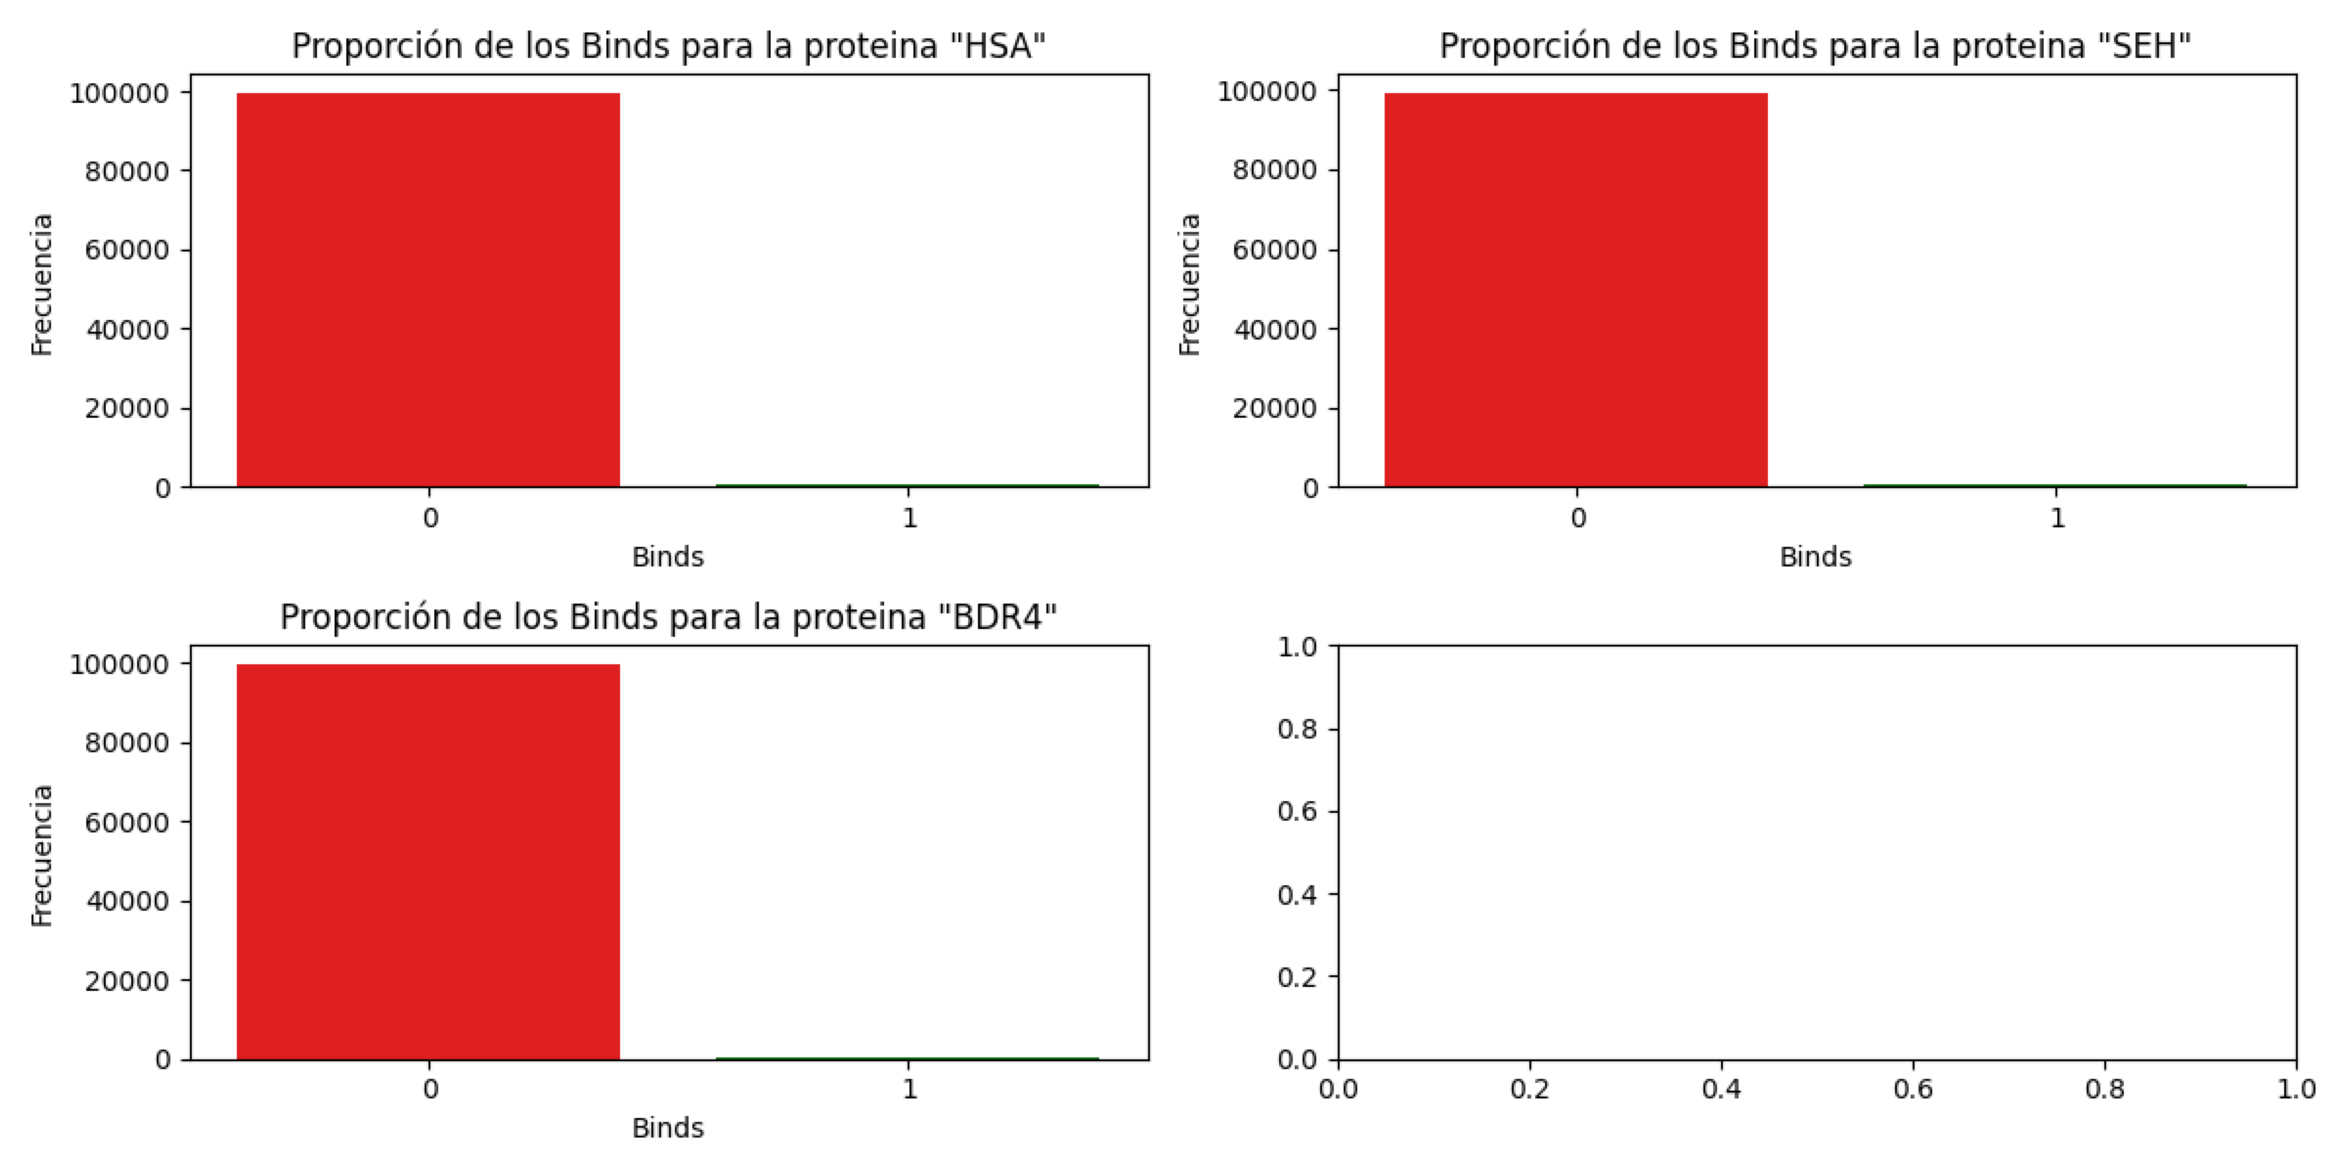

In [62]:
'''fig, axs = plt.subplots(2, 2, figsize=(12, 6))
sns.countplot(x = data_hsa['binds'], hue = data_hsa['binds'], palette = ['red', 'green'], legend = False, ax=axs[0][0])
axs[0][0].set_title('Proporción de los Binds para la proteina "HSA"')
axs[0][0].set_xlabel('Binds')
axs[0][0].set_ylabel('Frecuencia')

sns.countplot(x = data_seh['binds'], hue = data_seh['binds'], palette = ['red', 'green'], legend = False, ax=axs[0][1])
axs[0][1].set_title('Proporción de los Binds para la proteina "SEH"')
axs[0][1].set_xlabel('Binds')
axs[0][1].set_ylabel('Frecuencia')

sns.countplot(x = data_bd4['binds'], hue = data_bd4['binds'], palette = ['red', 'green'], legend = False, ax=axs[1][0])
axs[1][0].set_title('Proporción de los Binds para la proteina "BDR4"')
axs[1][0].set_xlabel('Binds')
axs[1][0].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()'''
plt.figure(figsize=(30, 20))  # Cambia los valores de (10, 10) para ajustar el tamaño

img = mpimg.imread('proporciones_bid1.png')
plt.imshow(img)
plt.axis('off')  
plt.show()

En este caso visualizamos la variable 'binds' en el datasets.

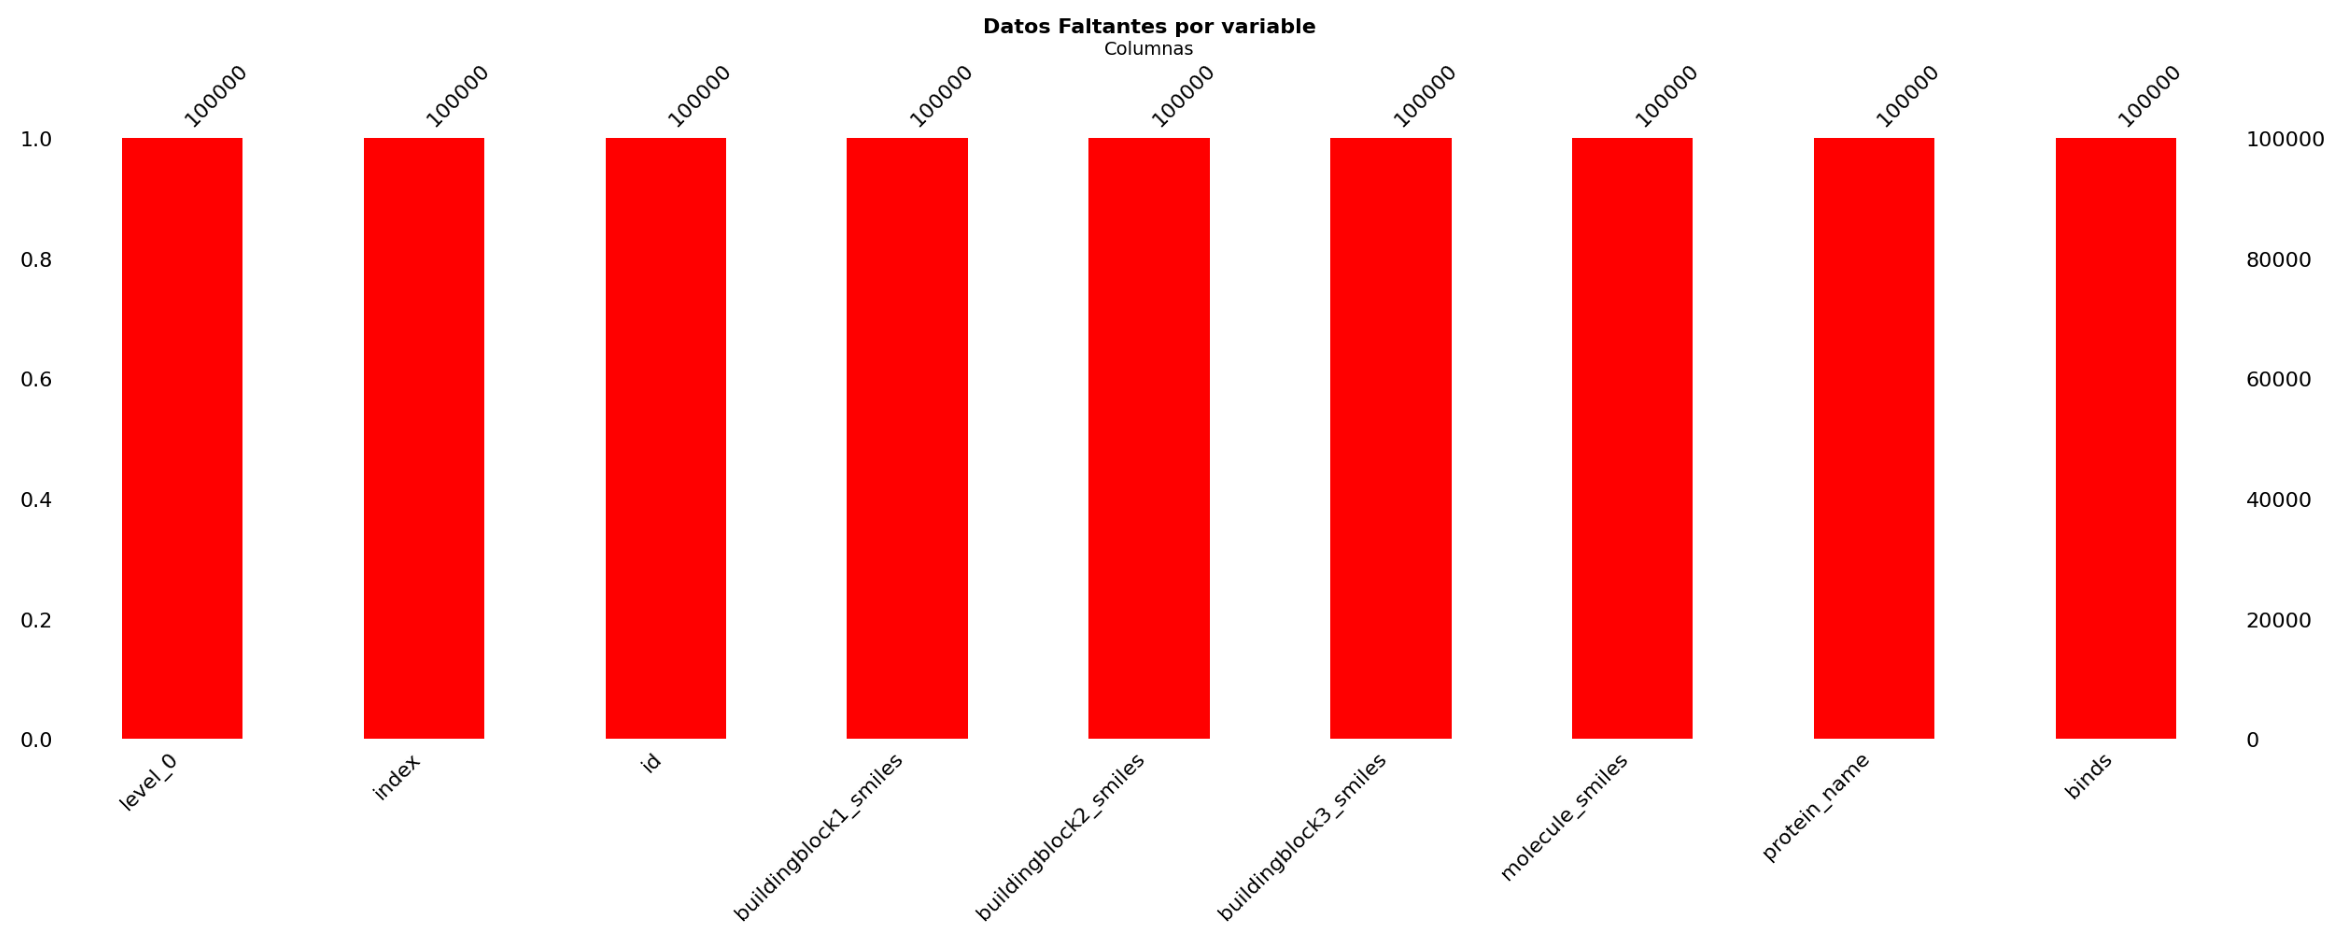

In [63]:
'''msno.bar(data_bd4, color = "red", sort = 'ascending')
plt.title('Datos Faltantes por variable', fontsize = 16, fontweight = 'bold')
plt.xlabel('Columnas', fontsize = 14)
plt.ylabel('Porcentaje de Datos Faltantes', fontsize = 14)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()'''
plt.figure(figsize=(30, 20))  
img = mpimg.imread('datos_faltantes1.png')
plt.imshow(img)
plt.axis('off')  
plt.show()

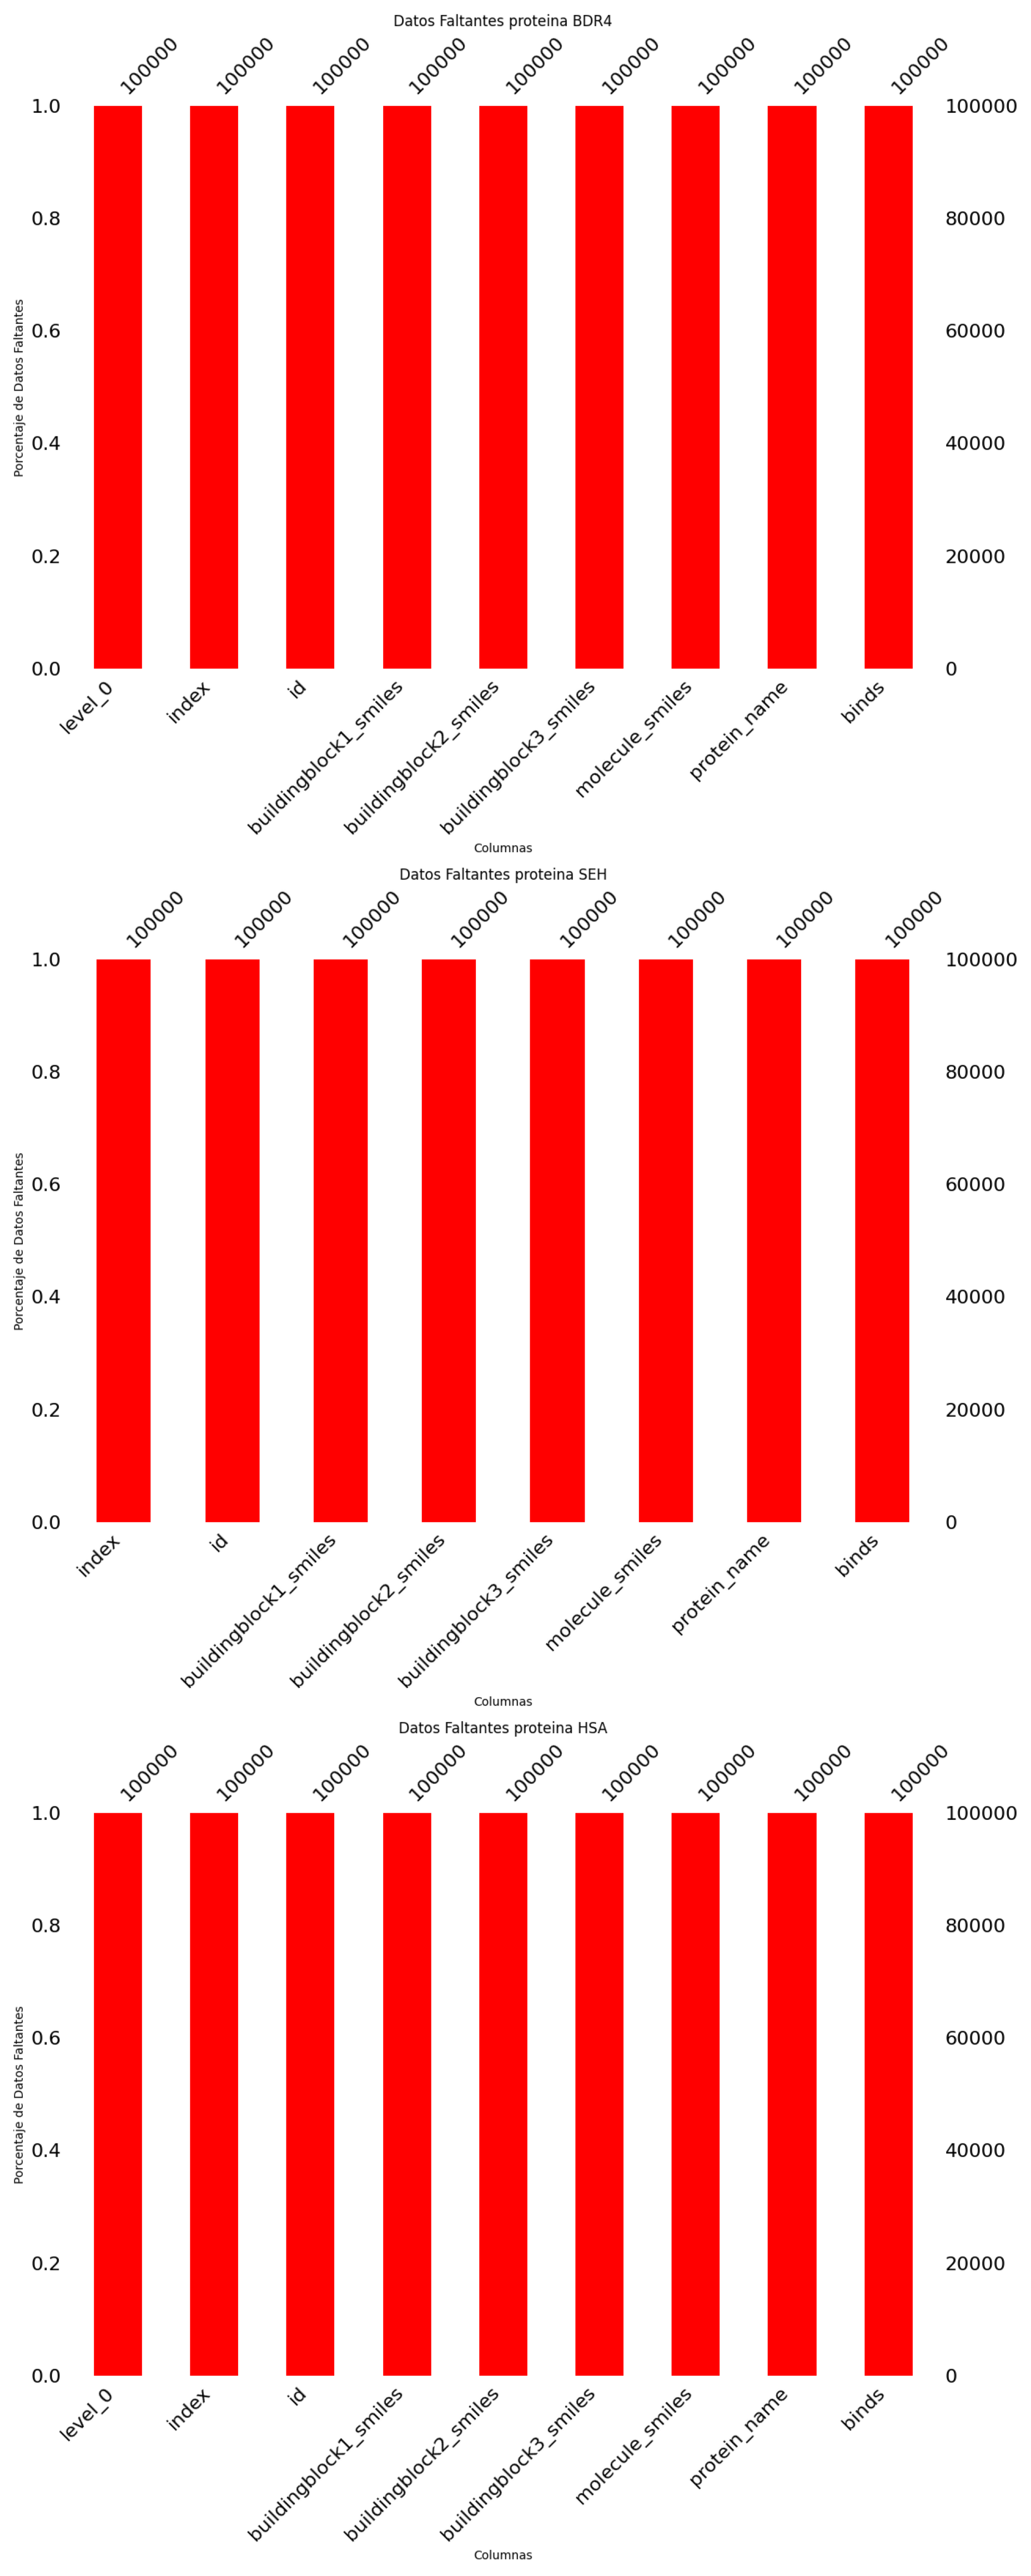

In [64]:
'''fig, axs = plt.subplots(3, 1, figsize=(12, 30))
msno.bar(data_bd4, color="red", sort='ascending', ax=axs[0])
axs[0].set_title('Datos Faltantes proteina BDR4')
axs[0].set_xlabel('Columnas')
axs[0].set_ylabel('Porcentaje de Datos Faltantes')
msno.bar(data_seh, color="red", sort='ascending', ax=axs[1])
axs[1].set_title('Datos Faltantes proteina SEH')
axs[1].set_xlabel('Columnas')
axs[1].set_ylabel('Porcentaje de Datos Faltantes')
msno.bar(data_hsa, color="red", sort='ascending', ax=axs[2])
axs[2].set_title('Datos Faltantes proteina HSA')
axs[2].set_xlabel('Columnas')
axs[2].set_ylabel('Porcentaje de Datos Faltantes')
plt.tight_layout()

# Mostrar los gráficos
plt.show()
'''
plt.figure(figsize=(30, 60))  
img = mpimg.imread('datos_faltantes2.png')
plt.imshow(img)
plt.axis('off')  
plt.show()

Aqui apreciamos la cantidad de datos faltantes a los dataframes inmediatos despues de hacer la particion por tipo de proteina. Vemos que no hay ninguna dato faltante en ninguna de las columnas, un caso ideal.

### Encode

In [65]:
'''data_seh = data_seh.reset_index()
categoricas = ['protein_name', 'buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles']
encoder1 = OneHotEncoder(sparse_output = False)
encoded1 = encoder1.fit_transform(data_seh[categoricas])
df_encoded1 = pd.DataFrame(encoded1, columns = encoder1.get_feature_names_out(categoricas))
hse_encoded  = pd.concat([data_seh, df_encoded1], axis = 1)
hse_encoded  = hse_encoded.drop(categoricas, axis = 1)
hse_encoded  = hse_encoded.drop(['molecule_smiles','id','index'], axis = 1)'''

"data_seh = data_seh.reset_index()\ncategoricas = ['protein_name', 'buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles']\nencoder1 = OneHotEncoder(sparse_output = False)\nencoded1 = encoder1.fit_transform(data_seh[categoricas])\ndf_encoded1 = pd.DataFrame(encoded1, columns = encoder1.get_feature_names_out(categoricas))\nhse_encoded  = pd.concat([data_seh, df_encoded1], axis = 1)\nhse_encoded  = hse_encoded.drop(categoricas, axis = 1)\nhse_encoded  = hse_encoded.drop(['molecule_smiles','id','index'], axis = 1)"

In [66]:
hse_encoded = pd.read_excel('seh_encoded.xlsx')
hse_encoded.head()

binds  protein_name_sEH  \
0      0                 1   
1      0                 1   
2      0                 1   
3      0                 1   
4      0                 1   

   buildingblock1_smiles_C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21  \
0                                                  0                       
1                                                  0                       
2                                                  0                       
3                                                  0                       
4                                                  0                       

   buildingblock1_smiles_C#CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O  \
0                                                  0                      
1                                                  0                      
2                                                  0                      
3                                                  0                      
4                                                  0                      

   buildingblock1_smiles_C#CC[C@@](C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O  \
0                                                  0                        
1                                                  0                        
2                                                  0                        
3                                                  0                        
4                                                  0                        

   buildingblock1_smiles_C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21  \
0                                                  0                      
1                                                  0                      
2                                                  0                      
3                                                  0                      
4                                                  0                      

   buildingblock1_smiles_C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O  \
0                                                  0                     
1                                                  0                     
2                                                  0                     
3                                                  0                     
4                                                  0                     

   buildingblock1_smiles_C=CCC(CC=C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O  \
0                                                  0                       
1                                                  0                       
2                                                  0                       
3                                                  0                       
4                                                  0                       

   buildingblock1_smiles_C=CCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O  \
0                                                  0                 
1                                                  0                 
2                                                  0                 
3                                                  0                 
4                                                  0                 

   buildingblock1_smiles_C=CCC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O  ...  \
0                                                  0                      ...   
1                                                  0                      ...   
2                                                  0                      ...   
3                                                  0                      ...   
4                                                  0                      ...   

   buildingblock3_smiles_Nc1ncnc(=O)[nH]1  \
0                                       0   
1                                       0   
2                                       0   
3         

In [67]:
'''data_hsa = data_hsa.reset_index()
categoricas = ['protein_name', 'buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles']
encoder2 = OneHotEncoder(sparse_output = False)
encoded2 = encoder2.fit_transform(data_hsa[categoricas])
df_encoded2 = pd.DataFrame(encoded2, columns = encoder2.get_feature_names_out(categoricas))
hsa_encoded  = pd.concat([data_hsa, df_encoded2], axis = 1)
hsa_encoded  = hsa_encoded.drop(categoricas, axis = 1)
hsa_encoded  = hsa_encoded.drop(['level_0','molecule_smiles','id','index'], axis = 'columns')'''


"data_hsa = data_hsa.reset_index()\ncategoricas = ['protein_name', 'buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles']\nencoder2 = OneHotEncoder(sparse_output = False)\nencoded2 = encoder2.fit_transform(data_hsa[categoricas])\ndf_encoded2 = pd.DataFrame(encoded2, columns = encoder2.get_feature_names_out(categoricas))\nhsa_encoded  = pd.concat([data_hsa, df_encoded2], axis = 1)\nhsa_encoded  = hsa_encoded.drop(categoricas, axis = 1)\nhsa_encoded  = hsa_encoded.drop(['level_0','molecule_smiles','id','index'], axis = 'columns')"

In [68]:
hsa_encoded = pd.read_excel('hsa_encoded.xlsx')
hsa_encoded.head()

level_0  binds  protein_name_HSA  \
0        0      0                 1   
1        1      0                 1   
2        2      0                 1   
3        3      0                 1   
4        4      0                 1   

   buildingblock1_smiles_C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21  \
0                                                  0                       
1                                                  0                       
2                                                  0                       
3                                                  0                       
4                                                  0                       

   buildingblock1_smiles_C#CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O  \
0                                                  0                      
1                                                  0                      
2                                                  0                      
3                                                  0                      
4                                                  0                      

   buildingblock1_smiles_C#CC[C@@](C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O  \
0                                                  0                        
1                                                  0                        
2                                                  0                        
3                                                  0                        
4                                                  0                        

   buildingblock1_smiles_C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21  \
0                                                  0                      
1                                                  0                      
2                                                  0                      
3                                                  0                      
4                                                  0                      

   buildingblock1_smiles_C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O  \
0                                                  0                     
1                                                  0                     
2                                                  0                     
3                                                  0                     
4                                                  0                     

   buildingblock1_smiles_C=CCC(CC=C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O  \
0                                                  0                       
1                                                  0                       
2                                                  0                       
3                                                  0                       
4                                                  0                       

   buildingblock1_smiles_C=CCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O  ...  \
0                                                  0                ...   
1                                                  0                ...   
2                                                  0                ...   
3                                                  0                ...   
4                                                  0                ...   

   buildingblock3_smiles_Nc1ncnc(=O)[nH]1  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   

   buildingblock3_smiles_Nc1ncnc(Cl)c1Cl  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   buildingblock3_smiles_Nc1ncnc2[nH]cnc12  \
0          

In [69]:
'''data_bd4 = data_bd4.reset_index()
categoricas = ['protein_name', 'buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles']
encoder3 = OneHotEncoder(sparse_output = False)
encoded3 = encoder3.fit_transform(data_bd4[categoricas])
df_encoded3 = pd.DataFrame(encoded3, columns = encoder2.get_feature_names_out(categoricas))
bd4_encoded  = pd.concat([data_bd4, df_encoded3], axis = 1)
bd4_encoded = bd4_encoded.drop(['id','index','molecule_smiles','protein_name','buildingblock1_smiles','buildingblock2_smiles','buildingblock3_smiles'],axis='columns')
bd4_encoded.head()'''

"data_bd4 = data_bd4.reset_index()\ncategoricas = ['protein_name', 'buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles']\nencoder3 = OneHotEncoder(sparse_output = False)\nencoded3 = encoder3.fit_transform(data_bd4[categoricas])\ndf_encoded3 = pd.DataFrame(encoded3, columns = encoder2.get_feature_names_out(categoricas))\nbd4_encoded  = pd.concat([data_bd4, df_encoded3], axis = 1)\nbd4_encoded = bd4_encoded.drop(['id','index','molecule_smiles','protein_name','buildingblock1_smiles','buildingblock2_smiles','buildingblock3_smiles'],axis='columns')\nbd4_encoded.head()"

In [70]:
bd4_encoded = pd.read_excel('bd4_encoded.xlsx')
bd4_encoded.head()

level_0  binds  protein_name_HSA  \
0        0      0                 1   
1        1      0                 1   
2        2      0                 1   
3        3      0                 1   
4        4      0                 1   

   buildingblock1_smiles_C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21  \
0                                                  0                       
1                                                  0                       
2                                                  0                       
3                                                  0                       
4                                                  0                       

   buildingblock1_smiles_C#CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O  \
0                                                  0                      
1                                                  0                      
2                                                  0                      
3                                                  0                      
4                                                  0                      

   buildingblock1_smiles_C#CC[C@@](C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O  \
0                                                  0                        
1                                                  0                        
2                                                  0                        
3                                                  0                        
4                                                  0                        

   buildingblock1_smiles_C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21  \
0                                                  0                      
1                                                  0                      
2                                                  0                      
3                                                  0                      
4                                                  1                      

   buildingblock1_smiles_C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O  \
0                                                  0                     
1                                                  0                     
2                                                  0                     
3                                                  0                     
4                                                  0                     

   buildingblock1_smiles_C=CCC(CC=C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O  \
0                                                  0                       
1                                                  0                       
2                                                  0                       
3                                                  0                       
4                                                  0                       

   buildingblock1_smiles_C=CCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O  ...  \
0                                                  0                ...   
1                                                  0                ...   
2                                                  0                ...   
3                                                  0                ...   
4                                                  0                ...   

   buildingblock3_smiles_Nc1ncnc(=O)[nH]1  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   

   buildingblock3_smiles_Nc1ncnc(Cl)c1Cl  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   buildingblock3_smiles_Nc1ncnc2[nH]cnc12  \
0          

### Prueba Chi2

In [71]:
'''bind_hsa = hsa_encoded['binds']
k_best = SelectKBest(score_func = chi2, k = 90)
X_new1 = k_best.fit_transform(hsa_encoded, bind_hsa)
seleccion = k_best.get_support( indices= True)
hsa = hsa_encoded.iloc[:, seleccion]
hsa.head()'''
hsa = pd.read_excel('hsa.xlsx')
hsa.head()

level_0  binds  \
0        0      0   
1        1      0   
2        2      0   
3        3      0   
4        4      0   

   buildingblock1_smiles_CC(OC(C)(C)C)C(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O  \
0                                                  0                          
1                                                  0                          
2                                                  0                          
3                                                  0                          
4                                                  0                          

   buildingblock1_smiles_Cc1cc(Cl)cc(C(=O)O)c1NC(=O)OCC1c2ccccc2-c2ccccc21  \
0                                                  0                         
1                                                  0                         
2                                                  0                         
3                                                  0                         
4                                                  0                         

   buildingblock1_smiles_Cc1ccc(C(=O)O)cc1NC(=O)OCC1c2ccccc2-c2ccccc21  \
0                                                  0                     
1                                                  0                     
2                                                  0                     
3                                                  0                     
4                                                  0                     

   buildingblock1_smiles_O=C(NC(CC1CCCCC1)C(=O)O)OCC1c2ccccc2-c2ccccc21  \
0                                                  0                      
1                                                  0                      
2                                                  0                      
3                                                  0                      
4                                                  0                      

   buildingblock1_smiles_O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21  \
0                                                  0                      
1                                                  0                      
2                                                  0                      
3                                                  0                      
4                                                  0                      

   buildingblock1_smiles_O=C(N[C@@H](Cc1cccnc1)C(=O)O)OCC1c2ccccc2-c2ccccc21  \
0                                                  0                           
1                                                  0                           
2                                                  0                           
3                                                  0                           
4                                                  0                           

   buildingblock1_smiles_O=C(N[C@H](Cc1ccc(-c2ccccc2)cc1)C(=O)O)OCC1c2ccccc2-c2ccccc21  \
0                                                  0                                     
1                                                  0                                     
2                                                  0                                     
3                                                  0                                     
4                                                  0                                     

   buildingblock1_smiles_O=C(Nc1cc(C(=O)O)ccc1Cl)OCC1c2ccccc2-c2ccccc21  ...  \
0                                                  0                     ...   
1                                                  0                     ...   
2                                                  0                     ...   
3                                                  0                     ...   
4                                                  0                     ...   

   buildingblock3_smiles_Nc1cccc2ocnc12  buildingblock3_smiles_Nc1cn[nH]c1  \
0   

In [72]:
'''bind_hse = hse_encoded['binds']
k_best = SelectKBest(score_func = chi2, k = 90)
X_new = k_best.fit_transform(hse_encoded, bind_hse)
seleccion = k_best.get_support( indices= True)
seh = hse_encoded.iloc[:, seleccion]'''
seh = pd.read_excel('seh.xlsx')
seh.head( )

binds  \
0      0   
1      0   
2      0   
3      0   
4      0   

   buildingblock1_smiles_O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21  \
0                                                  0                      
1                                                  0                      
2                                                  0                      
3                                                  0                      
4                                                  0                      

   buildingblock1_smiles_O=C(NCC1CCC(C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21  \
0                                                  0                     
1                                                  0                     
2                                                  0                     
3                                                  0                     
4                                                  0                     

   buildingblock1_smiles_O=C(NC[C@H]1CC[C@H](C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21  \
0                                                  0                             
1                                                  0                             
2                                                  0                             
3                                                  0                             
4                                                  0                             

   buildingblock1_smiles_O=C(N[C@@H](Cc1cccnc1)C(=O)O)OCC1c2ccccc2-c2ccccc21  \
0                                                  0                           
1                                                  0                           
2                                                  0                           
3                                                  0                           
4                                                  0                           

   buildingblock1_smiles_O=C(N[C@H](Cc1ccc(F)c(F)c1)C(=O)O)OCC1c2ccccc2-c2ccccc21  \
0                                                  0                                
1                                                  0                                
2                                                  0                                
3                                                  0                                
4                                                  0                                

   buildingblock1_smiles_O=C(Nc1ccc(C(=O)O)cc1O)OCC1c2ccccc2-c2ccccc21  \
0                                                  0                     
1                                                  0                     
2                                                  0                     
3                                                  0                     
4                                                  0                     

   buildingblock1_smiles_O=C(Nc1ccc(C(=O)O)nc1)OCC1c2ccccc2-c2ccccc21  \
0                                                  0                    
1                                                  0                    
2                                                  0                    
3                                                  0                    
4                                                  0                    

   buildingblock1_smiles_O=C(Nc1cnccc1C(=O)O)OCC1c2ccccc2-c2ccccc21  \
0                                                  0                  
1                                                  0                  
2                                                  0                  
3                                                  0                  
4                                                  0                  

   buildingblock2_smiles_C=CCOC(C)CN  ...  buildingblock3_smiles_NCc1ccsc1Br  \
0                                  0  ...                                  0   
1                                  0  ...                                  0  

In [73]:
'''bind_bd4 = bd4_encoded['binds']
k_best = SelectKBest(score_func = chi2, k = 90)
X_new = k_best.fit_transform(bd4_encoded, bind_bd4)
seleccion = k_best.get_support( indices= True)
bd4 = bd4_encoded.iloc[:, seleccion]'''
bd4 = pd.read_excel('bd4.xlsx')
bd4.head( )

binds  \
0      0   
1      0   
2      0   
3      0   
4      0   

   buildingblock1_smiles_CC(C)(C)OC(=O)CCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O  \
0                                                  0                             
1                                                  0                             
2                                                  0                             
3                                                  0                             
4                                                  0                             

   buildingblock1_smiles_CC(C)(C)OCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O  \
0                                                  0                       
1                                                  0                       
2                                                  0                       
3                                                  0                       
4                                                  0                       

   buildingblock1_smiles_CC(C)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O  \
0                                                  0                   
1                                                  0                   
2                                                  0                   
3                                                  0                   
4                                                  0                   

   buildingblock1_smiles_CC(OC(C)(C)C)C(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O  \
0                                                  0                          
1                                                  0                          
2                                                  0                          
3                                                  0                          
4                                                  0                          

   buildingblock1_smiles_N#Cc1ccc(C[C@@H](NC(=O)OCC2c3ccccc3-c3ccccc32)C(=O)O)cc1  \
0                                                  0                                
1                                                  0                                
2                                                  0                                
3                                                  0                                
4                                                  0                                

   buildingblock1_smiles_O=C(NC(CC1CCCCC1)C(=O)O)OCC1c2ccccc2-c2ccccc21  \
0                                                  0                      
1                                                  0                      
2                                                  0                      
3                                                  0                      
4                                                  0                      

   buildingblock1_smiles_O=C(NC(CCc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21  \
0                                                  0                       
1                                                  0                       
2                                                  0                       
3                                                  0                       
4                                                  0                       

   buildingblock1_smiles_O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21  \
0                                                  0                      
1                                                  0                      
2                                                  0                      
3                                                  0                      
4                                                  0                      

   buildingblock1_smiles_O=C(N[C@H](Cc1ccc(F)c(F)c1)C(=O)O)OCC1c2ccccc2-c2ccccc21  \
0                                                  0                                
1                               

Finalmente se redujo la multicolinealidad con la prueba de chi2 y se obtuvieron tres DataFrames debido a la divison por proteina realizada, cada uno de estos con 5 columnas y 90 filas.

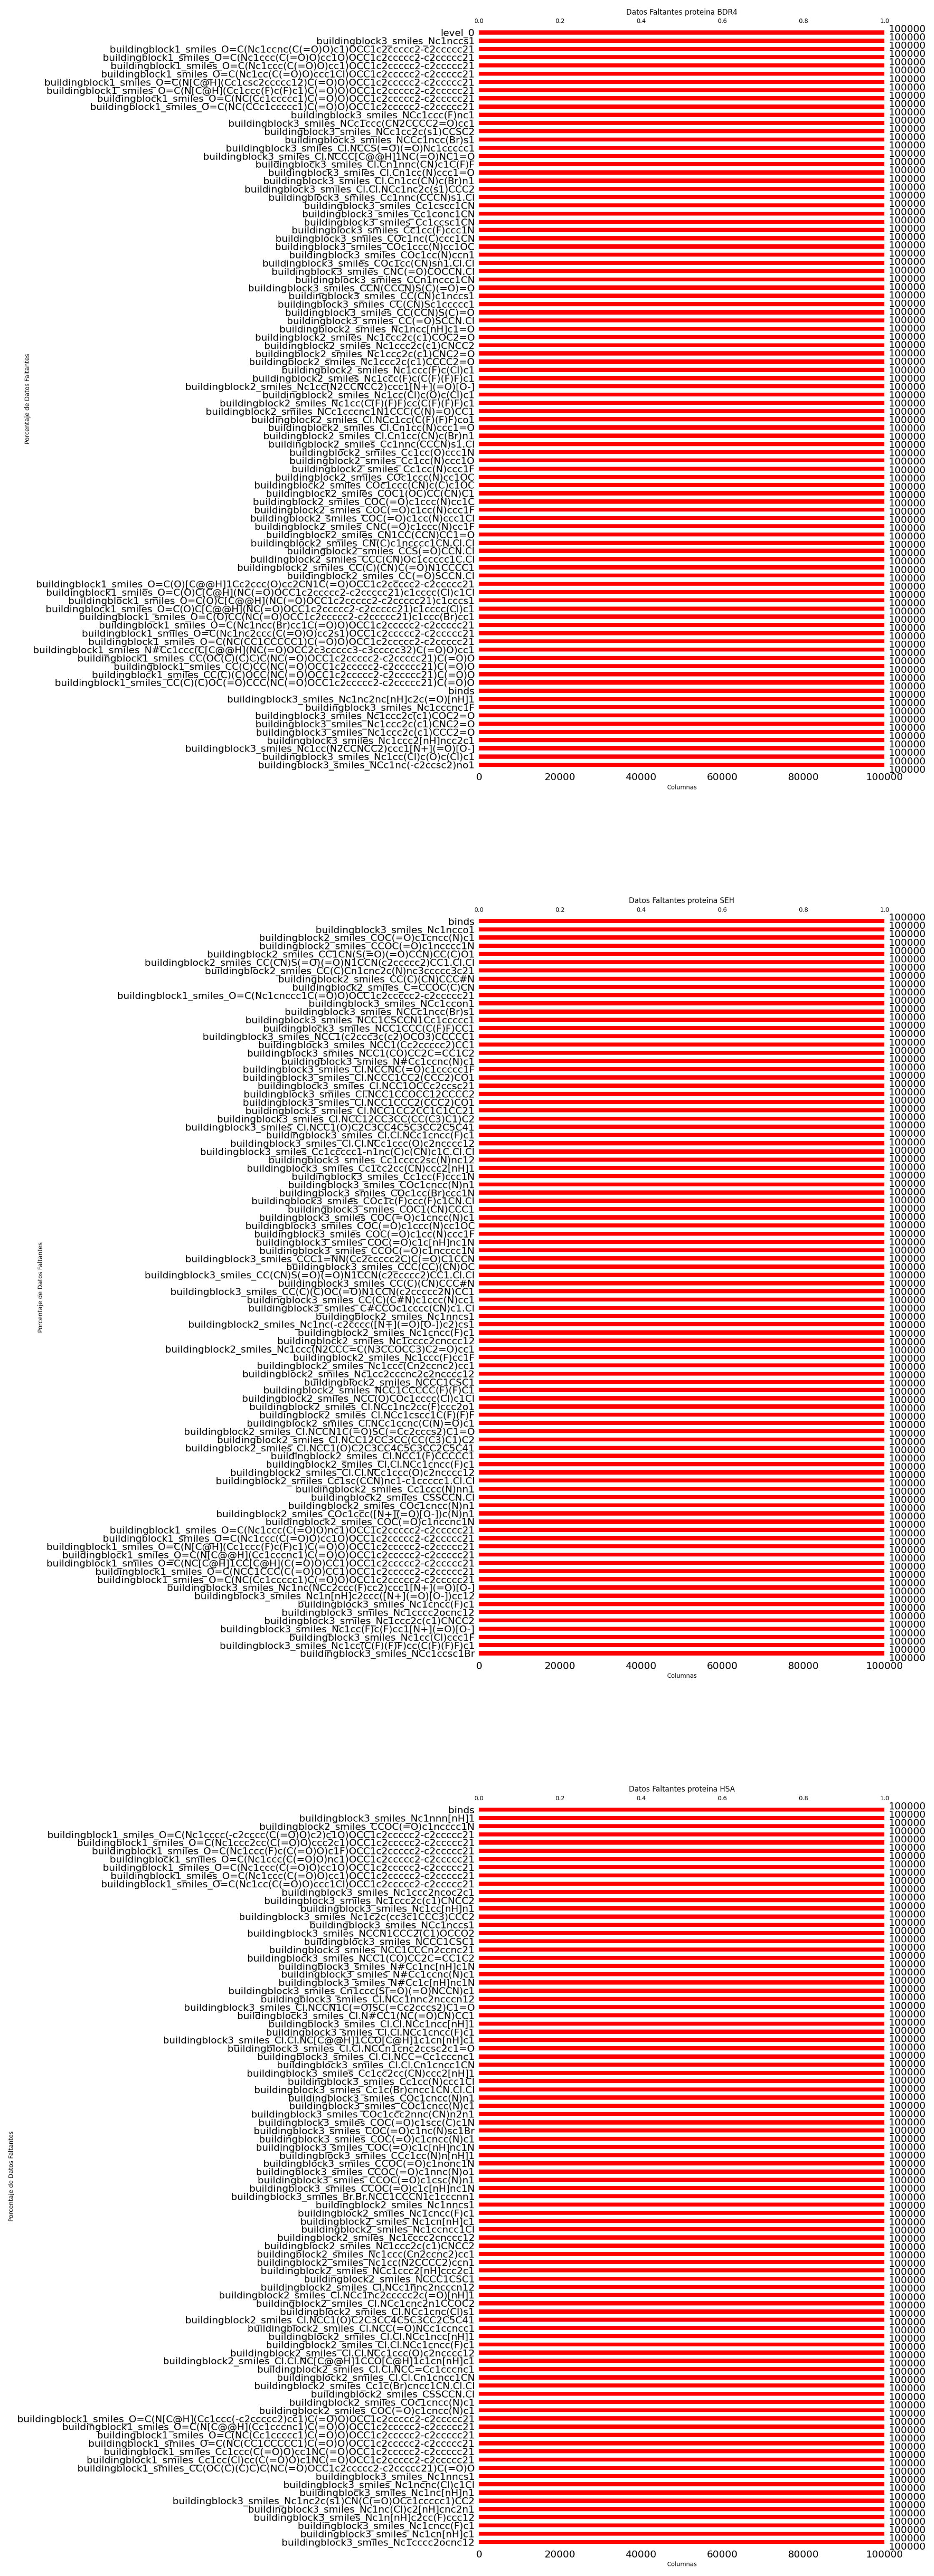

In [74]:
'''fig, axs = plt.subplots(3, 1, figsize=(12, 75))
msno.bar(bd4, color="red", sort='ascending', ax=axs[0])
axs[0].set_title('Datos Faltantes proteina BDR4')
axs[0].set_xlabel('Columnas')
axs[0].set_ylabel('Porcentaje de Datos Faltantes')
msno.bar(seh, color="red", sort='ascending', ax=axs[1])
axs[1].set_title('Datos Faltantes proteina SEH')
axs[1].set_xlabel('Columnas')
axs[1].set_ylabel('Porcentaje de Datos Faltantes')
msno.bar(hsa, color="red", sort='ascending', ax=axs[2])
axs[2].set_title('Datos Faltantes proteina HSA')
axs[2].set_xlabel('Columnas')
axs[2].set_ylabel('Porcentaje de Datos Faltantes')
plt.tight_layout()
plt.show()'''

plt.figure(figsize=(30, 80))  
img = mpimg.imread('datos_faltantes3.png')
plt.imshow(img)
plt.axis('off')  
plt.show()

Finalmente, medimos los datos faltantes para los dataframes resultantes que van a entrar a los modelos KNN y regresion logsitica. Hallamos que no hay un solo valor faltante para ninguna variable.